**OBJECTIVE:** Edit the `item-price` column so it can be safely converted to a float

In [1]:
import os

import numpy as np
import pandas as pd

from lets_plot import *
LetsPlot.setup_html()

from IPython.display import Image

# 1. Read all CSV files into a single data frame

In [2]:
# Identify the location of the original files
# This represents the path: ../data/waitrose-2024-07
data_folder = os.path.join('..', 'data', 'supermarket', 'waitrose-2024-07')

# Use a list comprehension to get all the files in the folder
all_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) 
             if file.endswith('.csv')]

# Print the list of files if you want to check
# print(all_files)

# Read every single file as a DataFrame
# Save the dataframes in a list
list_of_dfs = [pd.read_csv(file) for file in all_files]

# Use pd.concat to concatenate all the files into a single DataFrame
df = pd.concat(list_of_dfs)

# Check that we have all the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25418 entries, 0 to 1593
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data-product-id        25418 non-null  int64  
 1   data-product-name      25418 non-null  object 
 2   data-product-type      25418 non-null  object 
 3   data-product-on-offer  25418 non-null  bool   
 4   data-product-index     25408 non-null  float64
 5   image-url              25418 non-null  object 
 6   product-page           25418 non-null  object 
 7   product-name           25407 non-null  object 
 8   product-size           25363 non-null  object 
 9   item-price             25407 non-null  object 
 10  price-per-unit         24976 non-null  object 
 11  offer-description      7201 non-null   object 
 12  category               25418 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 2.5+ MB


# 2. Exploring the `item-price` column

<div style="background-color:white;padding:0.5em;margin-left:0em;margin-bottom:1em;border-radius:0.5em;font-family: monospace;border: 1px solid #eda291;font-size:0.9em;width:70%;line-height:1em">

**What did I learn? What are the different formatting scenarios?**

1. Some numbers are in the format `£10.00` (with the pound symbol)
    - I just need to remove the pound symbol from those 
    - 96% of the data was in this format

2. Some are in the format `75p` (indicating pences)
    - Those I need to convert to `0.75`
    - 3% of the data was in this format

3. There are cases with `each est.` 
    - Examples: `£4.76 each est.` and `10p each est.`
    - If I remove the `' each est.'` string first, then the rest of the string can be treated like the other scenarios above.
    - 1.5% of the data was in this format

4. There are cases with a range of values, like '£55-£110 each est.'
    - 0.20% of the cases seem to be in this format

5. Finally, there are a few lines with item_price equals to `NaN`. 
    - This is likely some error in the script that downloaded the data. 
    - There's nothing we can do but delete these lines from the dataframe

**Problems I found along the way**

- Before any pre-processing, I tried `df['item-price'].astype(float)` but, of course, it threw an error. That's how I started to discover the formatting scenarios above.

- I created a first version of the `clean_item_price()` function that removed the `£` with the method `"some_string".replace("£", "")` 
    - I learned about `replace()` from previous weeks, but I also found it on the Python's official documentation [here](https://docs.python.org/3/library/stdtypes.html#str.replace).

- But then I got an error saying that a float does not have the `replace()` method. I fixed it by forcing the `item_price` variable in the function to a string.
    - `replace()` is only defined for string objects.

</div>

In [3]:
# The data type of this column is 'O' (object)
df['item-price'].dtype

dtype('O')

⚠️ When a column (a pd.Series) is of type object, this means that pandas could not discern a specific data type (numeric types, boolean, datetime, etc) for this column. Frequently, this means the data is a string, but it could be that some objects are strings, others are numbers, others are something else. 

**To treat this column as a column of strings, I will have to convert each element to a string explicitly with the `str()` method, or the entire column with `astype(str)`**

## Validation

How do I know if the column can be converted to floats?

I used the `pandas.Series.astype(float)` function: 


```python
# This is a way to validate if my column can be converted to float
# If the column is clean, this will not throw an error
df['item-price'].astype(float)
```

```python
ValueError: could not convert string to float: '£10.00'
```

GitHub Copilot pointed me an alternative way to check for errors in the conversion using AI.

I like this one as it doesn't throw any errors:

In [4]:
# Alternatively, I could check for errors like this:

total_invalid_numbers = pd.to_numeric(df['item-price'], errors='coerce').isna().sum()
ratio_invalid_numbers = 100*(total_invalid_numbers/len(df))

print(f"{ratio_invalid_numbers:.2f}% of the column cannot be directly converted to a float.")

100.00% of the column cannot be directly converted to a float.


## A fix for the problem

In [5]:
def clean_item_price(item_price: str): 

    # Force the item_price to be a string before doing anything else
    item_price = str(item_price)

    if ' each est.' in item_price:
        # Remove this string from item_price 
        # After this line, the same old code will still work!
        item_price = item_price.removesuffix(' each est.')

    if '-' in item_price:
        # If this has a range, like: item_price = '£55-£110'
        # The code below converts it to just '£55'
        item_price = item_price.split('-')[0]

    if '£' in item_price:
        # For example: item_price = '£1.99' --> '1.99'
        new_item_price = item_price.replace('£', '')
    elif item_price.endswith('p'):
        # For example: item_price = '75p' --> '0.75p'
        new_item_price = '0.' + item_price.replace('p', '')
    else:
        # Keep it as is and hope it doesn't throw any new errors
        new_item_price = item_price
    
    return new_item_price

Checking that the function above works for individual cases:

In [6]:
clean_item_price('£1.99')

'1.99'

In [7]:
clean_item_price('75p')

'0.75'

In [8]:
clean_item_price('£4.76 each est.')

'4.76'

In [9]:
clean_item_price('10p each est.')

'0.10'

In [10]:
clean_item_price('£55-£110')

'55'

In [11]:
# Awesome!
clean_item_price('£55-£110 each est.')

'55'

## Validation (again)

- Use the `apply()` function to modify all the elements of the column.
- Save the output to a separate Series
- Check how many elements of that new Series is now free of errors when converting to floats

In [12]:
# Alternatively, I could check for errors like this:

new_item_price = df['item-price'].apply(clean_item_price)

total_invalid_numbers = pd.to_numeric(new_item_price, errors='coerce').isna().sum()
ratio_invalid_numbers = 100*(total_invalid_numbers/len(df))

print(f"{ratio_invalid_numbers:.2f}% of the column cannot be directly converted to a float.")

0.04% of the column cannot be directly converted to a float.


**Success!** Nearly ALL of the data has been clean now! There are just 0.04% of cases with problems

## Final investigations

What are the remaining cases?

In [13]:
# Returns a boolean Series (just Trues and Falses)
# Whenever the output is True: 
#   it means that when pandas tried to convert it to a numeric, it saw a NaN (not a number)
# Whenever the output is False:
#   the clean_item_price() function removed the non-numerical characters
#   and pandas was able to convert the remaining string to a numerical without an issue
problematic_rows = pd.to_numeric(new_item_price, errors='coerce').isna()

# See how this looks like
problematic_rows

0       False
1       False
2       False
3       False
4       False
        ...  
1589    False
1590    False
1591    False
1592    False
1593    False
Name: item-price, Length: 25418, dtype: bool

How does df['item-price'] looks like for cases where `problematic_rows == True`?  

In [14]:
# 💡 Some strings have ranges of numbers! Adding to the list of scenarios above
df['item-price'][problematic_rows == True].head(20)

48    NaN
49    NaN
48    NaN
49    NaN
48    NaN
49    NaN
24    NaN
48    NaN
49    NaN
48    NaN
49    NaN
Name: item-price, dtype: object

These are NaN to begin with. That is, these items never had a price.

Instead of focusing just on the 'item-price' Series, let me look at more data about this product:

In [15]:
df[problematic_rows == True]

,data-product-id,data-product-name,data-product-type,data-product-on-offer,data-product-index,image-url,product-page,product-name,product-size,item-price,price-per-unit,offer-description,category
48,85201,Essential Leeks,G,False,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/essenti...,NaN,NaN,NaN,NaN,NaN,Dietary & Lifestyle
49,85513,Duchy Organic Carrots,G,False,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/duchy-o...,NaN,NaN,NaN,NaN,NaN,Dietary & Lifestyle
48,85247,Essential Cauliflower,G,False,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/essenti...,NaN,NaN,NaN,NaN,NaN,Fresh & Chilled
49,86535,Waitrose Cherry Vine Tomatoes,G,True,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/waitros...,NaN,NaN,NaN,NaN,25% Off. Was £2.35,Fresh & Chilled
48,722909,John Lewis Bumble Bee Napkin 33cm,G,True,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/john-le...,NaN,NaN,NaN,NaN,25% Off. Was £2.00,Home
49,624080,Cocktail Sticks Pot 150pk,G,False,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/cocktai...,NaN,NaN,NaN,NaN,NaN,Home
24,522601,Essential Pedal Bin Liners Tie Handles,G,False,25.0,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/essenti...,NaN,NaN,NaN,NaN,NaN,Household
48,522314,Waitrose Red Leicester Cheese & Sriracha Burge...,G,False,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/waitros...,NaN,NaN,NaN,NaN,NaN,Summer
49,750319,Waitrose 2 Lemon & Lime Daisy Cheesecakes,G,True,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/waitros...,NaN,NaN,NaN,NaN,25% Off. Was £4.00,Summer
48,67459,No.1 Royal Deeside Still Water,G,False,NaN,https://ecom-su-static-prod.wtrecom.com/images...,https://www.waitrose.com/ecom/products/no1-roy...,NaN,NaN,NaN,NaN,NaN,"Tea, Coffee & Soft Drinks"


This was either an error on the script that downloaded this data. When I look at the product pages online, they do have prices, but not on the data frame.

I'd say we remove these lines from the dataframe.

# 3. Recreating the `item-price` column

Now that I know my function works, let me substitute the item-price column for the new version.

I will do this in a few steps.

In [16]:
# Step 1: Identify the valid rows (those that do not contain a NaN number for item-price)

# The tilde in Pandas inverts the boolean values.
# Whatever was True because False and vice versa
valid_rows = ~ problematic_rows

print(f"There are {sum(problematic_rows)} rows with NaN in the original DataFrame")
print(f"There will be {sum(valid_rows)} rows left once we remove those")

There are 11 rows with NaN in the original DataFrame
There will be 25407 rows left once we remove those


In [17]:
# Step 2: Filter the DataFrame to keep just the valid rows

df = df[valid_rows].copy()

In [18]:
# Step 3: Now I'm ready to apply the astype(float) function.
#         Let me test that it works first
#         IF THE CODE BELOW DOES NOT THROW ANY ERROR, THEN IT WORKED!
df['item-price'].apply(clean_item_price).astype(float)

0        3.15
1        3.15
2       13.50
3        0.95
4        1.60
        ...  
1589    24.31
1590     2.40
1591    10.00
1592     2.50
1593    21.49
Name: item-price, Length: 25407, dtype: float64

In [19]:
# Step 4: Because I can see the above worked, 
#         I will override the item-price column with its float version
df['item-price'] = df['item-price'].apply(clean_item_price).astype(float)

In [20]:
# Step 5: Check that it worked
df['item-price'].dtype

dtype('float64')

In [21]:
# All numbers are proper numbers. There isn't a single NaN here
df['item-price'].isna().sum() == 0

True

# 4. Plotting the Data

Even though I don't understand the code below, this should work. I just had to add an import to the top

In [22]:

plot_df = (
    df.groupby('category')['item-price'].describe()
        .reset_index()
        .rename(columns={'25%': 'Q1', '50%': 'median', '75%': 'Q3'})
        .sort_values(by='median')
)

# plot_df.head() to see how it looks like

# This configures what shows up when you hover your mouse over the plot.
tooltip_setup = (
    layer_tooltips()
        .line('@category')
        .line('[@Q1 -- @median -- @Q3]')
        .format('@Q1', '£ {.2f}')
        .format('@median', '£ {.2f}')
        .format('@Q3', '£ {.2f}')
)

g = (
    # Maps the columns to the aesthetics of the plot.
    ggplot(plot_df, aes(y='category', x='median', xmin='Q1', xmax='Q3', fill='category')) +

    # GEOMS

    # Add a line range that 'listens to' columns informed in `ymin` and `ymax` aesthetics
    geom_linerange(size=1, alpha=0.75, tooltips=tooltip_setup) +

    # Add points to the plot (listen to `x` and `y` and fill aesthetics)
    geom_point(size=3, stroke=1, shape=21, tooltips=tooltip_setup) +

    # SCALES

    # Remove the legend (we can already read the categories from the y-axis)
    scale_fill_discrete(guide='none') +

    # Specify names for the axes
    scale_y_continuous(name="Categories\n(from largest to smallest median)", expand=[0.05, 0.05]) +
    scale_x_continuous(name="Price (£)", expand=[0., 0.05], format='£ {.2f}', breaks=np.arange(0, 20, 2.5)) +

    # LABELS
    # It's nice when the plot tells you the key takeaways
    labs(title='"Beer, Wine & Spirits" has the highest median price for individual items',
         subtitle="Dots represent the median price, bars represent the 25th and 75th percentiles") +
    theme(axis_text_x=element_text(size=15),
        axis_text_y=element_text(size=17),
        axis_title_x=element_text(size=20),
        axis_title_y=element_text(size=20),
        plot_title=element_text(size=19, face='bold'),
        plot_subtitle=element_text(size=18),
        legend_position='none') +
    ggsize(1000, 500)

)

# g

In [23]:
ggsave(g, "waitrose-median-price-by-category.png", path='../figures/supermarket/')

'c:\\Users\\Jon\\Workspace\\ds105a-2024\\figures\\supermarket\\waitrose-median-price-by-category.png'

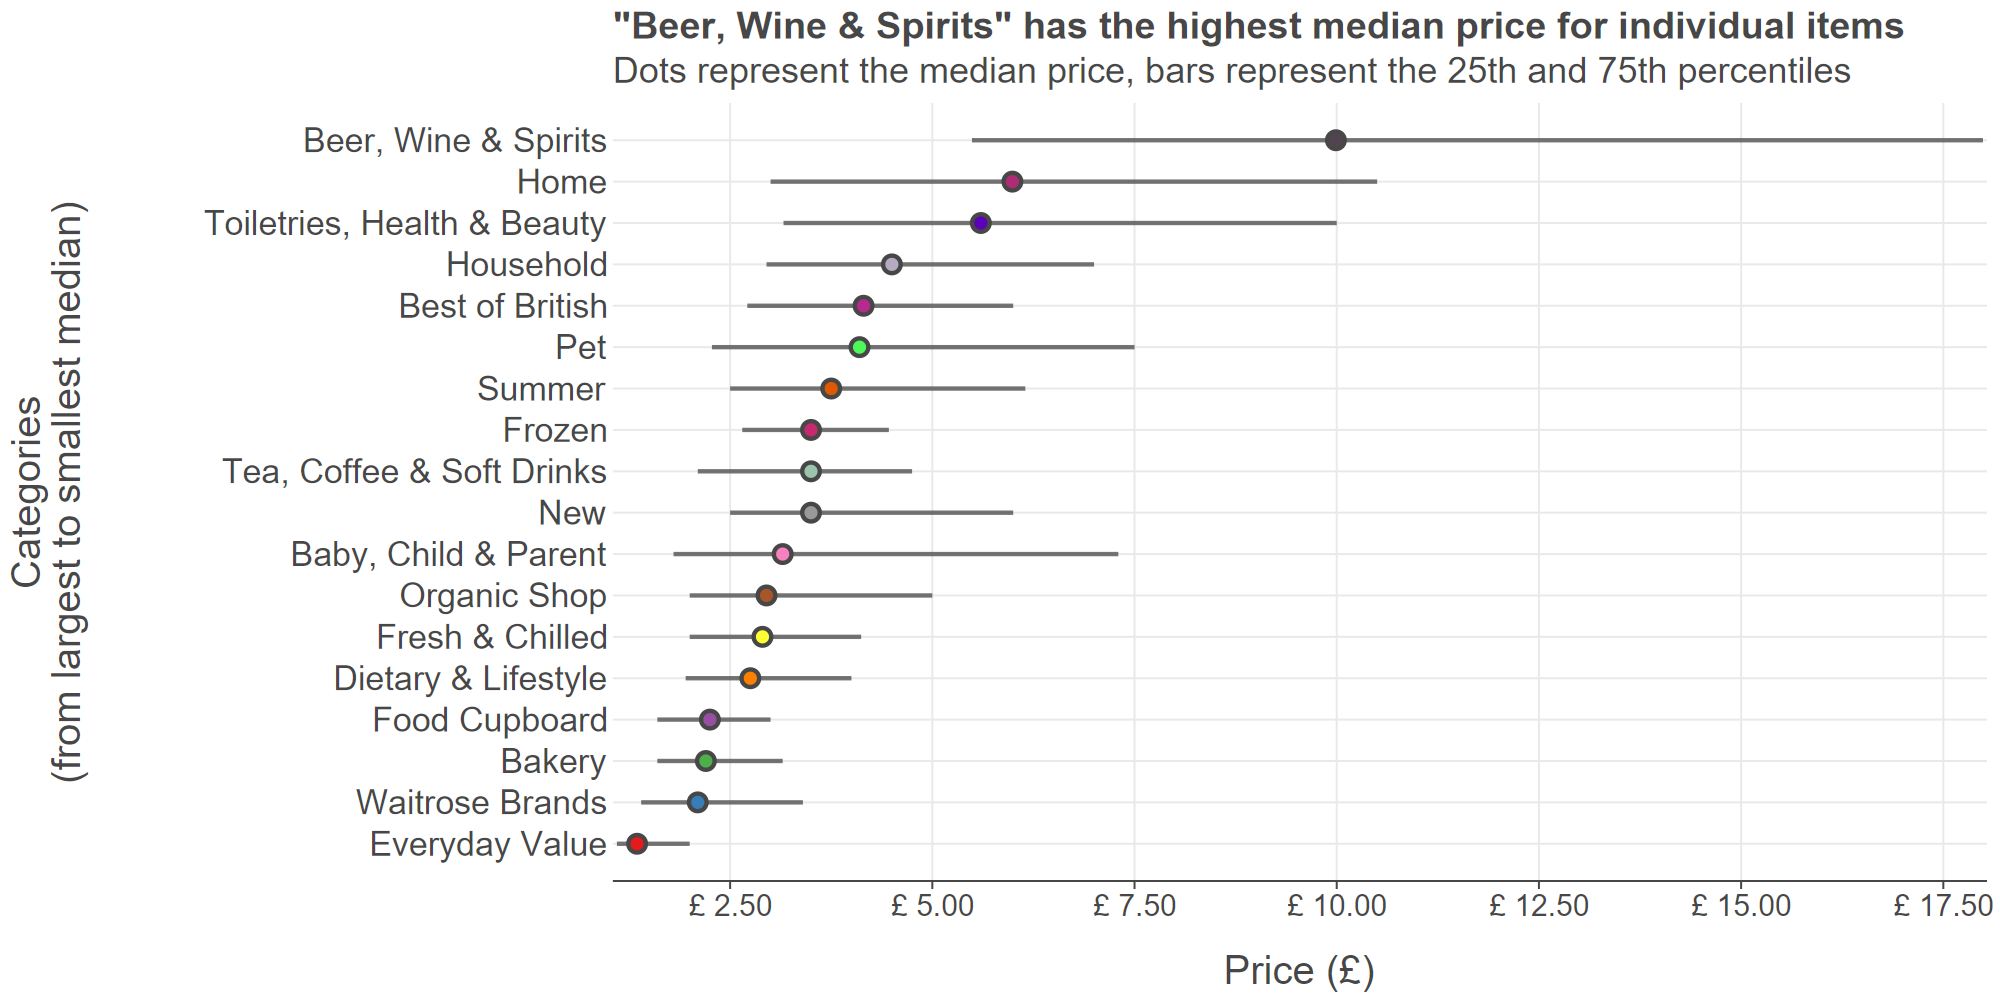

In [24]:
Image("../figures/supermarket/waitrose-median-price-by-category.png")

**I CAN SEE A PLOT ABOVE WHEN I RUN THE ENTIRE NOTEBOOK FROM TOP TO BOTTOM!!**